In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
df_holidays = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv', header = 0)
df_oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv', header = 0)
df_stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv', header = 0)
df_trans = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv', header = 0)

df_train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv', header = 0)
df_test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv', header = 0)

In [3]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'], format = "%Y-%m-%d")
df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
df_train['date'] = pd.to_datetime(df_train['date'], format = "%Y-%m-%d")
df_test['date'] = pd.to_datetime(df_test['date'], format = "%Y-%m-%d")

# Visualization

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

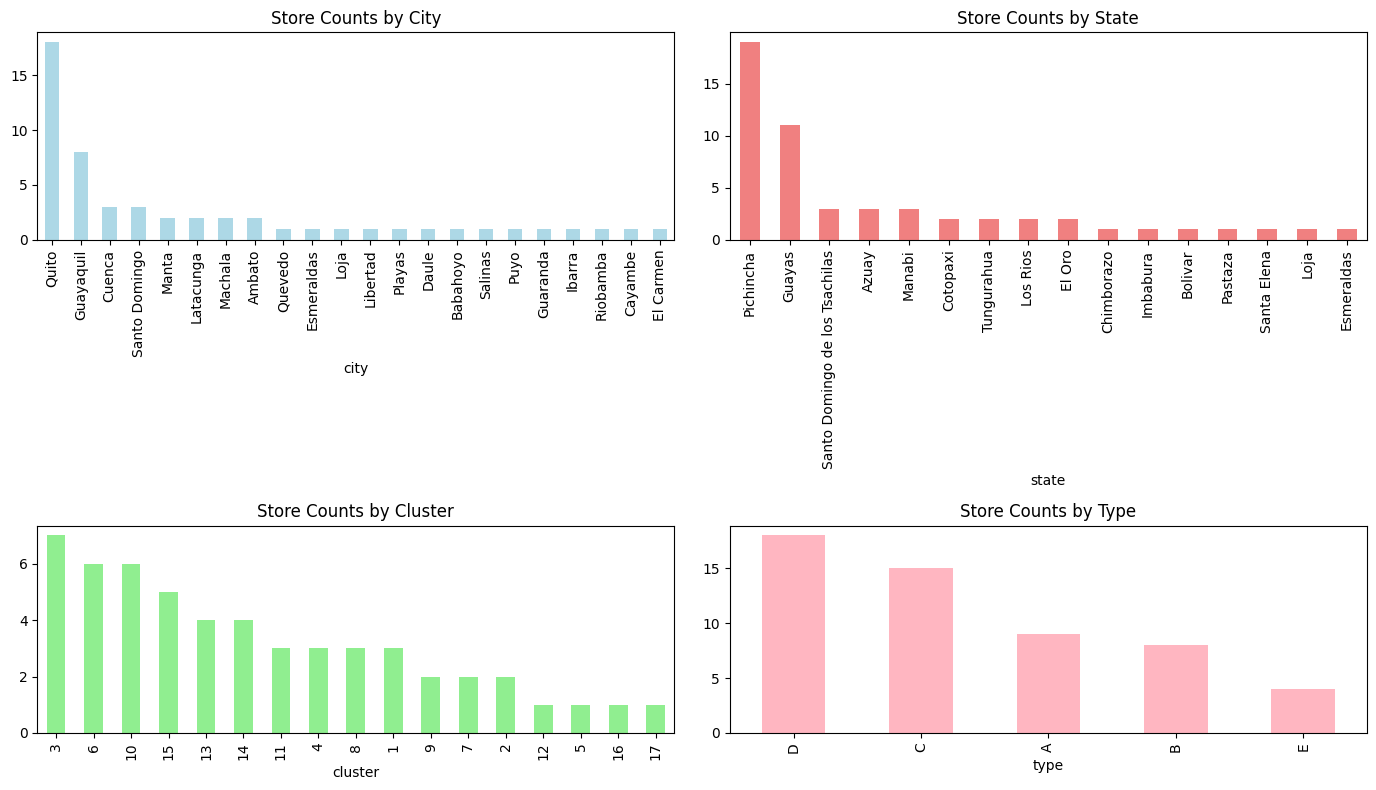

In [5]:
plt.figure(figsize=(14, 8))

# Create subplots for each category
plt.subplot(2, 2, 1)
df_stores['city'].value_counts().plot(kind='bar', color='lightblue')
plt.title('Store Counts by City')

plt.subplot(2, 2, 2)
df_stores['state'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Store Counts by State')

plt.subplot(2, 2, 3)
df_stores['cluster'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Store Counts by Cluster')

plt.subplot(2, 2, 4)
df_stores['type'].value_counts().plot(kind='bar', color='lightpink')
plt.title('Store Counts by Type')

plt.tight_layout()
plt.show()

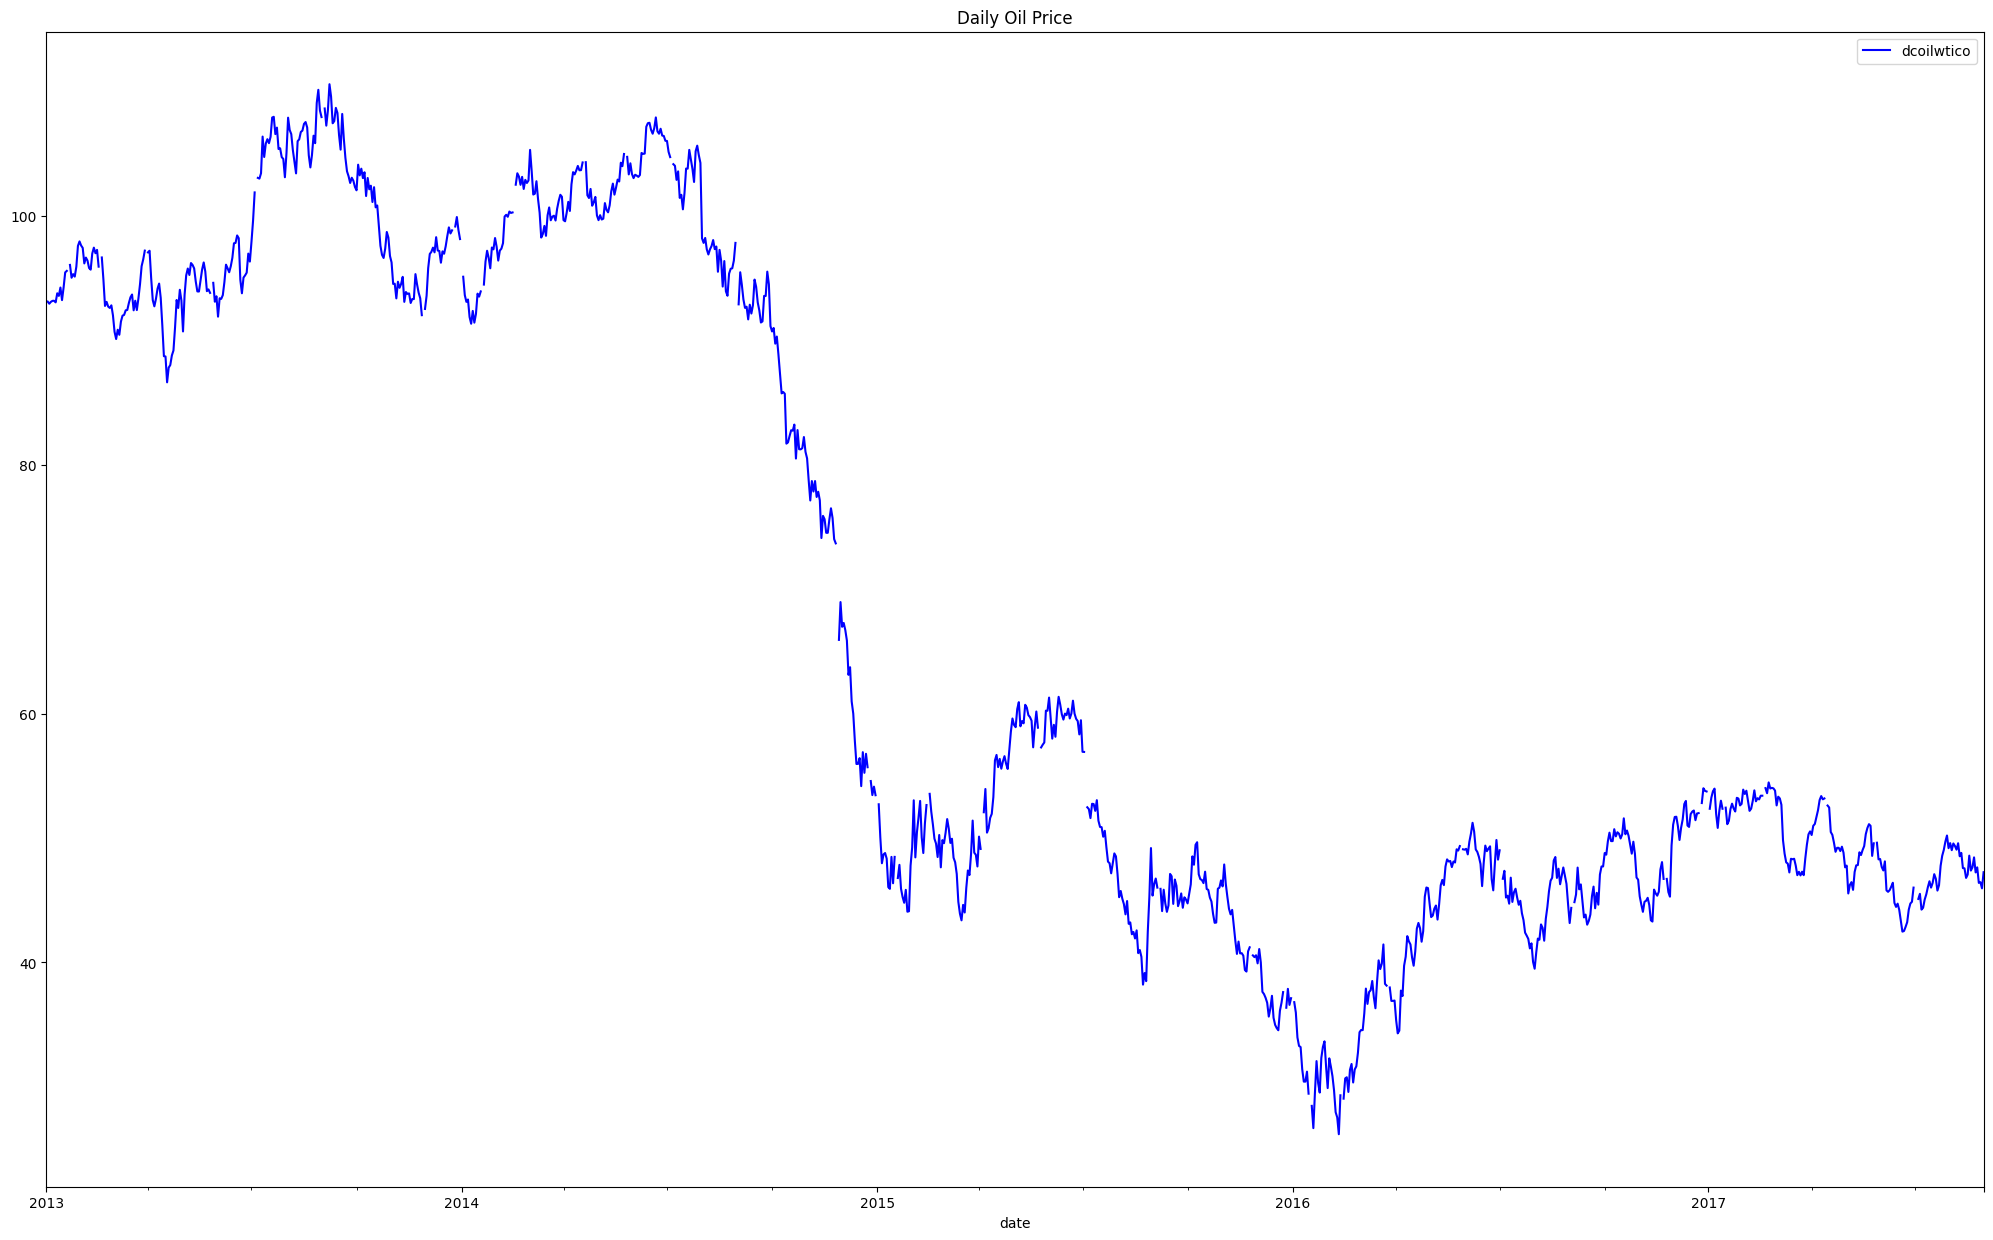

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
df_oil.plot.line(x="date", y="dcoilwtico", color='b', title ="Daily Oil Price", ax = axes, rot=0)
plt.show()

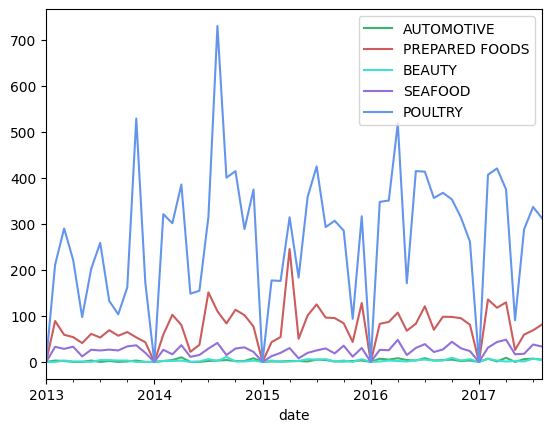

In [7]:
def plot_by_family(family, store, df, color, ax=None):
    store = df[(df['store_nbr'] == store) & (df['family'] == family)]
    result = store.groupby([store['date'].dt.year, store['date'].dt.month]).first().reset_index(drop=True)
    if ax is None:
        ax = plt.gca()  # Use the current axes if ax is not provided
    result.plot(x='date', y='sales', label=family, color=color, ax=ax)

# Create a new figure
plt.figure()

# Call the function for each family
plot_by_family('AUTOMOTIVE', 1, df_train, 'mediumseagreen')
plot_by_family('PREPARED FOODS', 1, df_train, 'indianred')
plot_by_family('BEAUTY', 1, df_train, 'turquoise')
plot_by_family('SEAFOOD', 1, df_train, 'mediumpurple')
plot_by_family('POULTRY', 1, df_train, 'cornflowerblue')

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [8]:
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [9]:
df_grouped_trans_w = grouped(df_trans, 'date', 'W', 'transactions')
df_grouped_trans_w

,date,mean
0,2013-01-06,1883.203463
1,2013-01-13,1641.090062
2,2013-01-20,1639.024845
3,2013-01-27,1609.816770
4,2013-02-03,1685.263975
...,...,...
237,2017-07-23,1623.208995
238,2017-07-30,1619.653439
239,2017-08-06,1713.743386
240,2017-08-13,1599.156085


In [10]:
def add_time(df, key, freq, col):
    """ ADD COLUMN 'TIME' TO DF """
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

In [11]:
df_grouped_train_w = add_time(df_train, 'date', 'W', 'sales')
df_grouped_train_m = add_time(df_train, 'date', 'M', 'sales')

df_grouped_train_w.head() # check results

,date,time,mean
0,2013-01-06,0,206.843478
1,2013-01-13,1,190.285220
2,2013-01-20,2,189.835452
3,2013-01-27,3,182.152050
4,2013-02-03,4,198.564267


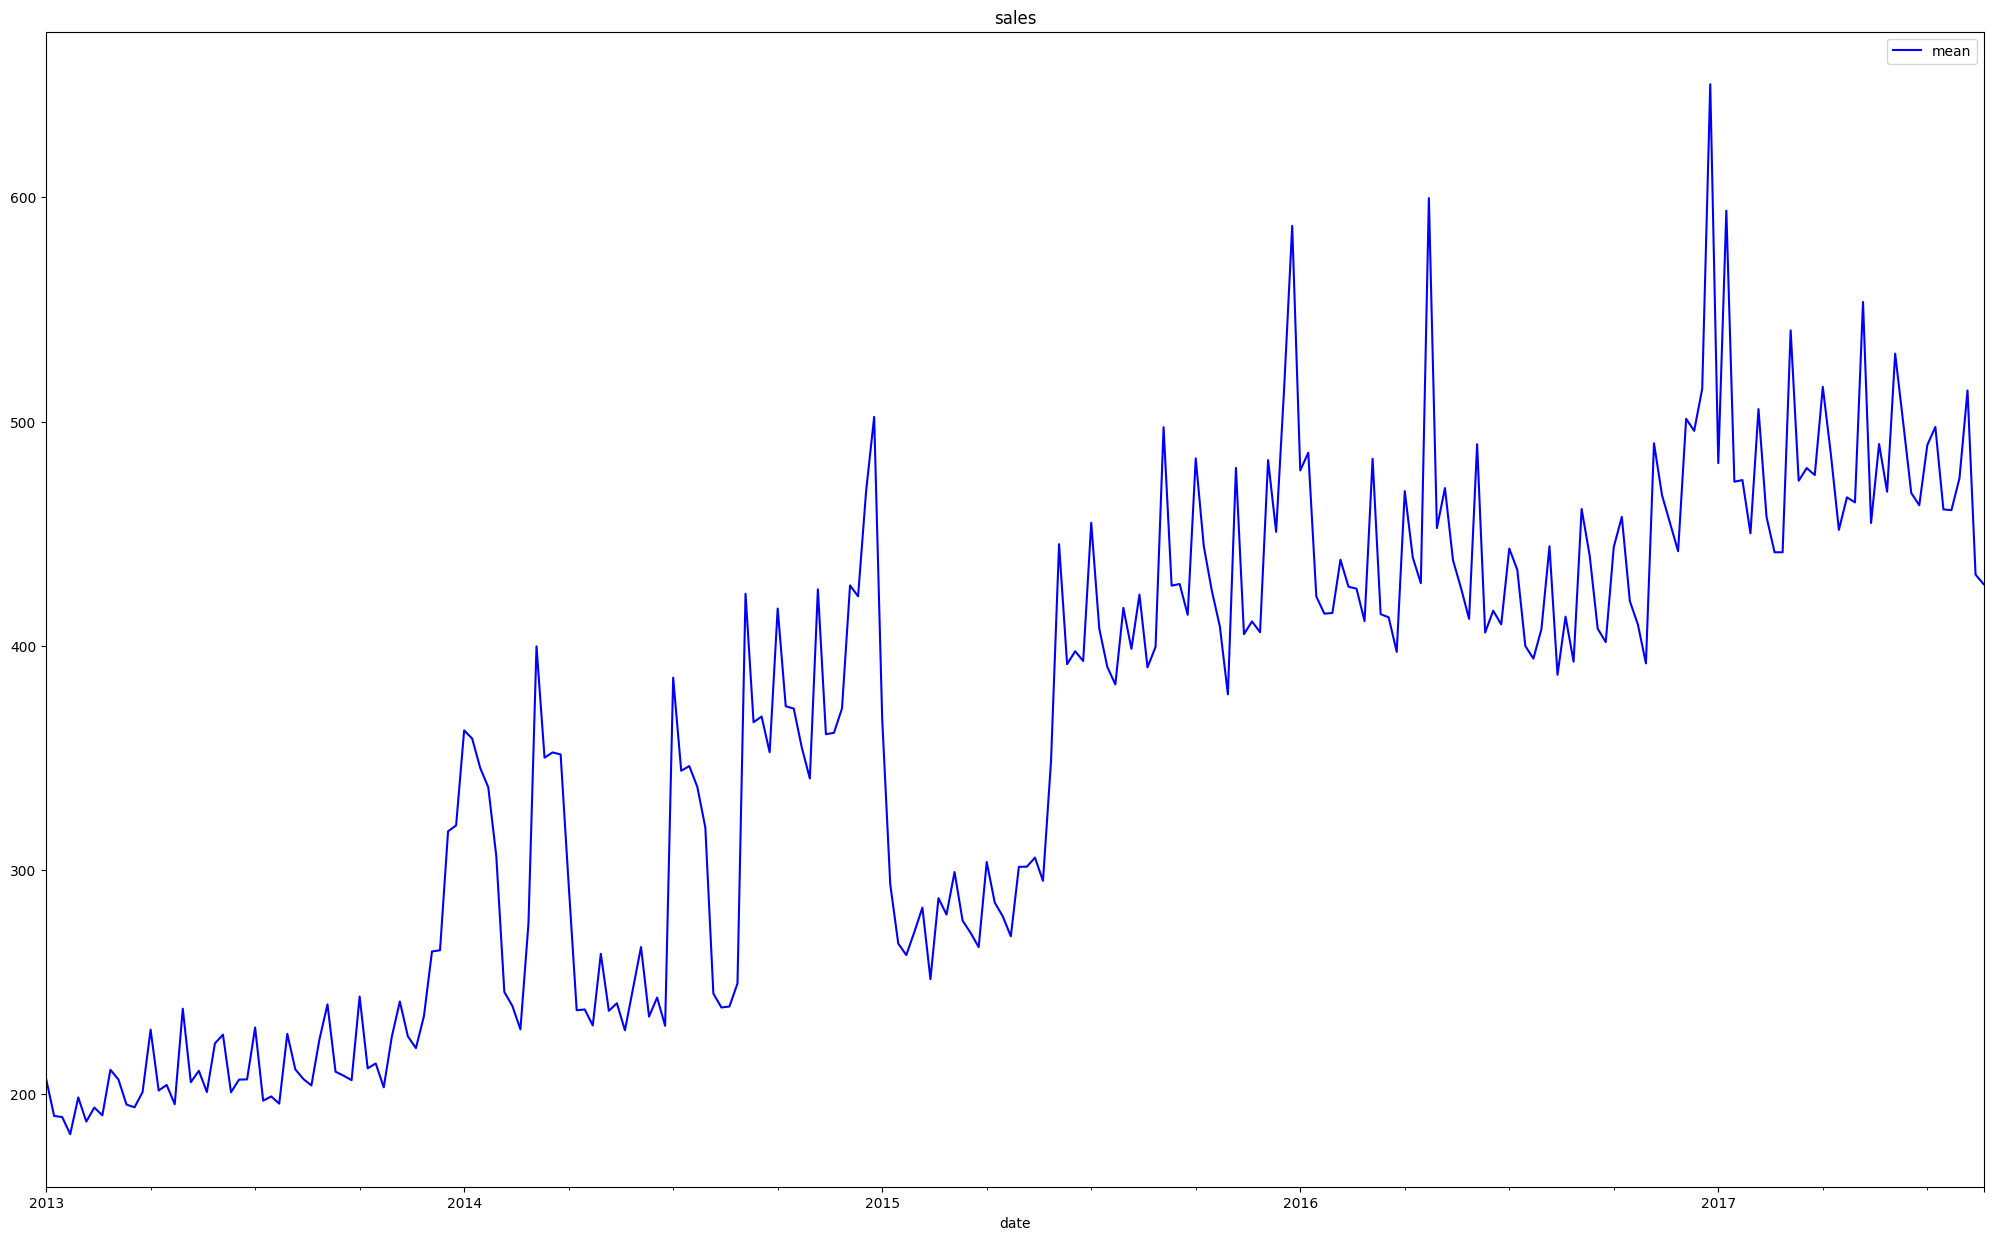

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
df_grouped_train_w.plot.line(x="date", y="mean", color='b', title ="sales", ax = axes, rot=0)
plt.show()

# Data Pre-Processing

In [13]:
df_holidays = df_holidays[(df_holidays['transferred'] == False) & (df_holidays['locale'] == 'National')]
df_holidays

,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [14]:
df_oil_processed = df_oil
df_oil_processed = df_oil_processed.fillna(method='ffill')
df_oil_processed['dcoilwtico'][0] = 93
df_oil_processed
# Drop NaN / Take from previous date 

/tmp/ipykernel_20/490503214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oil_processed['dcoilwtico'][0] = 93


,date,dcoilwtico
0,2013-01-01,93.00
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [15]:
df_train_processed = df_train.merge(df_oil_processed, on='date', how='left')
# df_train_processed = df_train_processed.fillna(df_train_processed.ffill())
# df_train_processed = df_train_processed.merge(df_stores, on='store_nbr', how='left')
df_train_processed = df_train_processed.merge(df_holidays, on='date', how='left')
df_train_processed['holiday_'] = df_train_processed['type'].notnull()
df_train_processed = df_train_processed[(df_train_processed['store_nbr'] == 1)]
df_train_processed = df_train_processed[['date', 'store_nbr', 'family', 'sales', 'onpromotion','dcoilwtico', 'holiday_']]
df_train_processed 

,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_
0,2013-01-01,1,AUTOMOTIVE,0.000000,0,93.00,True
1,2013-01-01,1,BABY CARE,0.000000,0,93.00,True
2,2013-01-01,1,BEAUTY,0.000000,0,93.00,True
3,2013-01-01,1,BEVERAGES,0.000000,0,93.00,True
4,2013-01-01,1,BOOKS,0.000000,0,93.00,True
...,...,...,...,...,...,...,...
3006262,2017-08-15,1,POULTRY,234.892000,0,47.57,False
3006263,2017-08-15,1,PREPARED FOODS,42.822998,0,47.57,False
3006264,2017-08-15,1,PRODUCE,2240.230000,7,47.57,False
3006265,2017-08-15,1,SCHOOL AND OFFICE SUPPLIES,0.000000,0,47.57,False


In [16]:
df_automotive_train = df_train_processed[(df_train_processed['family'] == 'POULTRY')]
df_automotive_train = df_automotive_train.fillna(0)
df_automotive_train['prev_1'] = df_automotive_train['sales'].shift(1)
df_automotive_train['prev_2'] = df_automotive_train['sales'].shift(2)
df_automotive_train['prev_1'][28] = df_automotive_train['prev_2'][28] = 0
df_automotive_train['prev_2'][1810] = 0
df_automotive_train

/tmp/ipykernel_20/833557952.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive_train['prev_1'][28] = df_automotive_train['prev_2'][28] = 0
/tmp/ipykernel_20/833557952.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive_train['prev_1'][28] = df_automotive_train['prev_2'][28] = 0
/tmp/ipykernel_20/833557952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive_train['prev_2'][1810] = 0


,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_,prev_1,prev_2
28,2013-01-01,1,POULTRY,0.00000,0,93.00,True,0.000,0.000
1810,2013-01-02,1,POULTRY,247.29700,0,93.14,False,0.000,0.000
3592,2013-01-03,1,POULTRY,187.27800,0,92.97,False,247.297,0.000
5374,2013-01-04,1,POULTRY,258.02300,0,93.12,False,187.278,247.297
7156,2013-01-05,1,POULTRY,212.33301,0,0.00,True,258.023,187.278
...,...,...,...,...,...,...,...,...,...
2999134,2017-08-11,1,POULTRY,259.11800,36,48.81,True,268.744,289.324
3000916,2017-08-12,1,POULTRY,217.66400,0,0.00,False,259.118,268.744
3002698,2017-08-13,1,POULTRY,115.75800,0,0.00,False,217.664,259.118
3004480,2017-08-14,1,POULTRY,270.04700,0,47.59,False,115.758,217.664


In [17]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

In [18]:
# df_automotive_train.drop(columns = ['sales', 'family'])
# df_automotive_train['date'] = (pd.to_datetime(df_automotive_train['date'], unit='ns').astype(int) // 10**9) 
# # city_encoder = LabelEncoder()
# # state_encoder = LabelEncoder()
# # type_encoder = LabelEncoder()
# # df_automotive_train['city'] = city_encoder.fit_transform(df_automotive_train['city'])
# # df_automotive_train['state'] = state_encoder.fit_transform(df_automotive_train['state'])
# # df_automotive_train['type_x'] = state_encoder.fit_transform(df_automotive_train['type_x'])
# df_automotive_train

In [19]:
import pandas as pd
from datetime import datetime, timedelta

def split_dataset_by_ratio(dataset, start_date, end_date, ratio=(6, 2, 2)):
    # Calculate the durations for each period based on the specified ratio
    total_duration = end_date - start_date
    train_duration = total_duration * (ratio[0] / 10)
    validation_duration = total_duration * (ratio[1] / 10)
    
    # Calculate the end dates for each period
    train_end_date = start_date + train_duration
    validation_end_date = train_end_date + validation_duration
    
    # Filter the dataset based on the calculated time periods
    train_set = dataset[(dataset['date'] >= start_date) & (dataset['date'] < train_end_date)]
    validation_set = dataset[(dataset['date'] >= train_end_date) & (dataset['date'] < validation_end_date)]
    test_set = dataset[(dataset['date'] >= validation_end_date) & (dataset['date'] <= end_date)]
    
    return train_set, validation_set, test_set


start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2017-08-15')

# Call the function to split the dataset
train_set, validation_set, test_set = split_dataset_by_ratio(df_automotive_train, start_date, end_date)

# Print the lengths of the resulting sets
print(f"Train Set Length: {len(train_set)}")
print(f"Validation Set Length: {len(validation_set)}")
print(f"Test Set Length: {len(test_set)}")


Train Set Length: 1012
Validation Set Length: 339
Test Set Length: 337


In [20]:
X_train = train_set.drop(['sales', 'family', 'store_nbr'], axis=1)
y_train = train_set['sales']
X_train['date'] = (pd.to_datetime(X_train['date'], unit='ns').astype(int) // 10**9) 
X_test = test_set.drop(['sales', 'family', 'store_nbr'], axis=1)
y_test = test_set['sales']
X_test['date'] = (pd.to_datetime(X_test['date'], unit='ns').astype(int) // 10**9) 
X_val = validation_set.drop(['sales', 'family', 'store_nbr'], axis=1)
y_val = validation_set['sales']
X_val['date'] = (pd.to_datetime(X_val['date'], unit='ns').astype(int) // 10**9) 

In [21]:
y_train

28           0.00000
1810       247.29700
3592       187.27800
5374       258.02300
7156       212.33301
             ...    
1794502    278.95700
1796284    338.59400
1798066    249.53000
1799848    195.10300
1801630    203.24800
Name: sales, Length: 1012, dtype: float64

In [22]:
y_train

28           0.00000
1810       247.29700
3592       187.27800
5374       258.02300
7156       212.33301
             ...    
1794502    278.95700
1796284    338.59400
1798066    249.53000
1799848    195.10300
1801630    203.24800
Name: sales, Length: 1012, dtype: float64

# RNN

In [23]:
import torch
from torch import nn, optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler

RNN_X_train = train_set
RNN_X_train = RNN_X_train.drop(['prev_1', 'prev_2','family', 'store_nbr'], axis=1)
RNN_X_train['date'] = (pd.to_datetime(RNN_X_train['date'], unit='ns').astype(int) // 10**9) 
RNN_X_val = validation_set
RNN_X_val = RNN_X_val.drop(['prev_1', 'prev_2', 'family', 'store_nbr'], axis=1)
RNN_X_val['date'] = (pd.to_datetime(RNN_X_val['date'], unit='ns').astype(int) // 10**9) 
RNN_X_test = test_set
RNN_X_test = RNN_X_test.drop(['prev_1', 'prev_2', 'family', 'store_nbr'], axis=1)
RNN_X_test['date'] = (pd.to_datetime(RNN_X_test['date'], unit='ns').astype(int) // 10**9) 

In [24]:
RNN_X_train

,date,sales,onpromotion,dcoilwtico,holiday_
28,1356998400,0.00000,0,93.00,True
1810,1357084800,247.29700,0,93.14,False
3592,1357171200,187.27800,0,92.97,False
5374,1357257600,258.02300,0,93.12,False
7156,1357344000,212.33301,0,0.00,True
...,...,...,...,...,...
1794502,1444089600,278.95700,0,48.53,False
1796284,1444176000,338.59400,0,47.86,False
1798066,1444262400,249.53000,0,49.46,False
1799848,1444348800,195.10300,26,49.67,True


In [25]:
# Initialize and fit scaler on X_train
feature_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = feature_scaler.fit_transform(RNN_X_train)

# Transform X_val and X_test using the same scaler
X_val_scaled = feature_scaler.transform(RNN_X_val)
X_test_scaled = feature_scaler.transform(RNN_X_test)

# Initialize and fit scaler on y_train (reshape if it's a Series)
target_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = target_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))

# Transform y_val and y_test using the same scaler (reshape if they're Series)
y_val_scaled = target_scaler.transform(y_val.to_numpy().reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.to_numpy().reshape(-1, 1))


# Convert scaled data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).flatten()
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).flatten()
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).flatten()

In [26]:
# Create sequences for X
def create_sequences(input_data, sequence_length):
    sequences = []
    data_size = len(input_data)
    for i in range(data_size - sequence_length):
        sequence = input_data[i:i + sequence_length]
        sequences.append(sequence)
    return torch.stack(sequences)

sequence_length = 5  # Adjust based on your data
X_train_sequences = create_sequences(X_train_tensor, sequence_length)
X_val_sequences = create_sequences(X_val_tensor, sequence_length)
X_test_sequences = create_sequences(X_test_tensor, sequence_length)

# Create sequences for y_train
def create_target_sequences(y_data, sequence_length):
    return y_data[sequence_length:]

y_train_sequences = create_target_sequences(y_train_tensor, sequence_length)
y_test_sequences = create_target_sequences(y_test_tensor, sequence_length)
y_val_sequences = create_target_sequences(y_val_tensor, sequence_length)

# Check shapes and alignment
print("Shape of X_val_sequences:", X_val_sequences.shape)
print("Shape of X_train_sequences:", X_train_sequences.shape)
print("Shape of X_test_sequences:", X_test_sequences.shape)

# Example check for alignment (adjust indices as needed)
print("Last element of first sequence:", X_train_sequences[0][-1])
print("First target element:", y_train_sequences[0])

Shape of X_val_sequences: torch.Size([334, 5, 5])
Shape of X_train_sequences: torch.Size([1007, 5, 5])
Shape of X_test_sequences: torch.Size([332, 5, 5])
Last element of first sequence: tensor([0.0040, 0.2381, 0.0000, 0.0000, 1.0000])
First target element: tensor(0.0827)


In [27]:
y_train_sequences

tensor([0.0827, 0.2448, 0.1861,  ..., 0.2798, 0.2188, 0.2279])

In [28]:
class SalesRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2):
        super(SalesRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, 1)  # Output size is 1 for regression

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Using the last time step
        return out

# Example parameters
input_size = 5  # Depends on your feature size
hidden_size = 20  # Adjusted based on dataset size
num_layers = 2    # Keeping it simple to avoid overfitting
dropout = 0.05     # Dropout for regularization

model = SalesRNN(input_size, hidden_size, num_layers, dropout)


In [29]:
# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training and validation loop
num_epochs = 200  # Number of epochs
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass - training
    outputs = model(X_train_sequences)
    loss = criterion(outputs.squeeze(), y_train_sequences)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_sequences)
        val_loss = criterion(val_outputs.squeeze(), y_val_sequences)
    val_losses.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [10/200], Train Loss: 0.0318, Val Loss: 0.0103
Epoch [20/200], Train Loss: 0.0231, Val Loss: 0.0078
Epoch [30/200], Train Loss: 0.0178, Val Loss: 0.0097
Epoch [40/200], Train Loss: 0.0166, Val Loss: 0.0130
Epoch [50/200], Train Loss: 0.0160, Val Loss: 0.0170
Epoch [60/200], Train Loss: 0.0150, Val Loss: 0.0139
Epoch [70/200], Train Loss: 0.0145, Val Loss: 0.0122
Epoch [80/200], Train Loss: 0.0133, Val Loss: 0.0108
Epoch [90/200], Train Loss: 0.0124, Val Loss: 0.0097
Epoch [100/200], Train Loss: 0.0118, Val Loss: 0.0075
Epoch [110/200], Train Loss: 0.0106, Val Loss: 0.0064
Epoch [120/200], Train Loss: 0.0088, Val Loss: 0.0058
Epoch [130/200], Train Loss: 0.0078, Val Loss: 0.0058
Epoch [140/200], Train Loss: 0.0066, Val Loss: 0.0062
Epoch [150/200], Train Loss: 0.0061, Val Loss: 0.0059
Epoch [160/200], Train Loss: 0.0057, Val Loss: 0.0053
Epoch [170/200], Train Loss: 0.0055, Val Loss: 0.0051
Epoch [180/200], Train Loss: 0.0054, Val Loss: 0.0050
Epoch [190/200], Train Loss: 0.0051, 

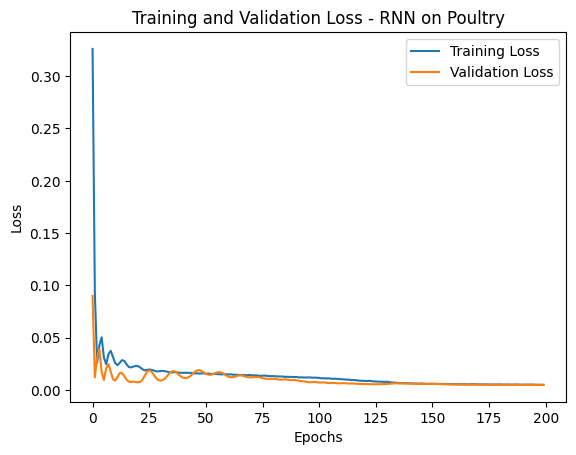

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.title('Training and Validation Loss - RNN on Poultry')
plt.legend()
plt.show()


In [31]:
# Ensure the model is in evaluation mode
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_sequences)
    
test_predictions_np = test_predictions.view(-1).numpy()

# Convert the scaled predictions back to the original scale
original_scale_predictions = target_scaler.inverse_transform(test_predictions_np.reshape(-1, 1))

# Flatten the array to a 1D array for easier interpretation
original_scale_predictions = original_scale_predictions.flatten()

# Display the predictions
original_scale_predictions

array([291.79007, 134.48712, 293.007  , 292.7877 , 341.71048, 270.2608 ,
       366.5336 , 295.99747, 142.31642, 289.91763, 289.69443, 332.782  ,
       265.43323, 365.3675 , 291.122  , 147.07452, 287.9015 , 298.62878,
       345.1734 , 265.05435, 374.87198, 294.07294, 144.77225, 294.28125,
       288.79416, 357.3475 , 275.18793, 361.36978, 285.84753, 131.77167,
       293.76013, 293.1694 , 346.3248 , 260.92377, 380.81165, 297.44278,
       153.18456, 290.0676 , 294.69693, 343.3787 , 266.97934, 378.42572,
       308.80185, 145.2029 , 290.92645, 293.21585, 336.86716, 267.2097 ,
       343.16376, 285.0686 , 121.09409, 279.62488, 273.73068, 328.28613,
       279.57013, 374.5177 , 307.38882, 176.5994 , 286.79227, 304.9109 ,
       351.60065, 263.16443, 366.94714, 304.7809 , 150.11612, 300.55975,
       300.54544, 354.80502, 269.08267, 376.908  , 298.72208, 135.37263,
       301.54645, 284.74716, 336.4655 , 295.7174 , 372.47763, 293.96753,
       152.77438, 296.49304, 301.30716, 347.81485, 

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert y_test to a numpy array and flatten
# Make sure the length of y_test_np aligns with the number of predictions
y_test_np = y_test.iloc[-332:].to_numpy().flatten()

# Calculate MAE and MSE using the unscaled predictions and original y_test values
mae = mean_absolute_error(y_test_np, original_scale_predictions)
mse = mean_squared_error(y_test_np, original_scale_predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")


Mean Absolute Error (MAE): 54.74166007580567
Mean Squared Error (MSE): 5581.109109878163


In [33]:
y_test_np

array([277.28    , 155.13    , 306.569   , 265.107   , 304.716   ,
       311.087   , 361.791   , 288.444   , 147.101   , 232.799   ,
       290.54    , 309.47    , 192.61299 , 404.969   , 353.391   ,
       156.687   , 301.595   , 258.736   , 314.005   , 264.317   ,
       428.036   , 310.656   , 150.653   , 351.026   , 227.565   ,
       319.23502 , 225.823   , 425.572   , 346.793   , 113.819   ,
       302.715   , 249.37    , 362.719   , 281.744   , 449.517   ,
       314.977   , 118.732   , 307.42    , 339.189   , 294.76    ,
       332.852   , 444.997   , 249.374   , 131.799   , 326.922   ,
       314.268   , 159.443   , 114.61    , 279.768   , 204.857   ,
       159.825   , 328.004   , 315.881   , 418.961   , 278.084   ,
       496.644   , 301.731   , 161.797   , 332.519   , 305.959   ,
       321.201   , 292.28    , 477.406   , 380.447   , 129.478   ,
       342.947   , 299.301   , 377.599   , 260.988   , 394.809   ,
       236.224   , 151.464   , 286.851   , 318.257   , 376.032

In [34]:
rnn_results = {'Predict': original_scale_predictions, 'Actual':y_test_np}
rnn_results = pd.DataFrame(rnn_results)
rnn_results

,Predict,Actual
0,291.790070,277.280
1,134.487122,155.130
2,293.006989,306.569
3,292.787689,265.107
4,341.710480,304.716
...,...,...
327,373.736267,259.118
328,292.921173,217.664
329,142.766464,115.758
330,281.063965,270.047


### XGBoost

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb 
from sklearn.metrics import mean_squared_log_error, accuracy_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [36]:
# XG_X_train, XG_X_val, XG_X_test, XG_y_train, XG_y_val, XG_y_test  = X_train, X_val, X_test, y_train, y_val, y_test
# # XG_X_train
# XG_X_train['date'] = pd.to_numeric(X_train['date'])
# XG_X_val['date'] = pd.to_numeric(X_val['date'])
# XG_X_test['date'] = pd.to_numeric(X_test['date'])

In [37]:
# XG_X_train

In [38]:
xgb_model = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate=0.01, eval_metric='rmsle')
xgb_model.fit(X_train, y_train, eval_set=[(X_train,y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-rmsle:4.09926	validation_1-rmsle:4.16989
[1]	validation_0-rmsle:3.62823	validation_1-rmsle:3.68602
[2]	validation_0-rmsle:3.31500	validation_1-rmsle:3.36618
[3]	validation_0-rmsle:3.07991	validation_1-rmsle:3.14638
[4]	validation_0-rmsle:2.89226	validation_1-rmsle:2.95374
[5]	validation_0-rmsle:2.73605	validation_1-rmsle:2.80891
[6]	validation_0-rmsle:2.60250	validation_1-rmsle:2.65598
[7]	validation_0-rmsle:2.48631	validation_1-rmsle:2.54966
[8]	validation_0-rmsle:2.38324	validation_1-rmsle:2.44546
[9]	validation_0-rmsle:2.29103	validation_1-rmsle:2.34198
[10]	validation_0-rmsle:2.20755	validation_1-rmsle:2.26650
[11]	validation_0-rmsle:2.13122	validation_1-rmsle:2.18152
[12]	validation_0-rmsle:2.06134	validation_1-rmsle:2.11851
[13]	validation_0-rmsle:1.99668	validation_1-rmsle:2.05498
[14]	validation_0-rmsle:1.93666	validation_1-rmsle:1.98811
[15]	validation_0-rmsle:1.88064	validation_1-rmsle:1.93747
[16]	validation_0-rmsle:1.82897	validation_1-rmsle:1.87901
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

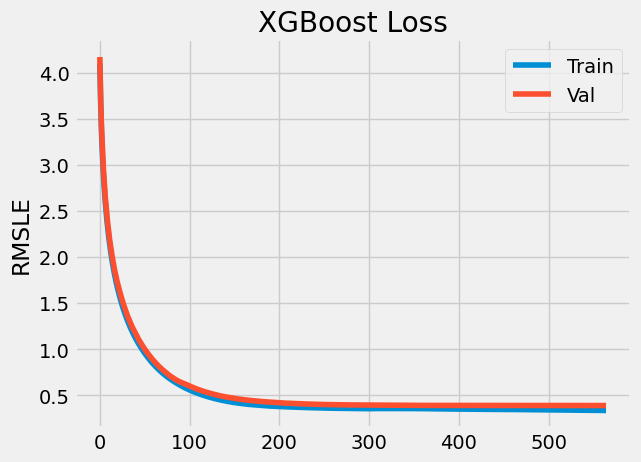

In [39]:
xg_loss = xgb_model.evals_result()
epochs = len(xg_loss['validation_0']['rmsle'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, xg_loss['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, xg_loss['validation_1']['rmsle'], label='Val')
ax.legend()
plt.ylabel('RMSLE')
plt.title('XGBoost Loss')
plt.show()

In [40]:
xg_results = {'Predict': xgb_model.predict(X_test), 'Actual':y_test}
xg_results = pd.DataFrame(xg_results)
xg_results

,Predict,Actual
2407510,292.137268,339.713
2409292,280.358337,279.873
2411074,258.265167,299.072
2412856,265.311035,270.934
2414638,400.079132,436.373
...,...,...
2999134,406.142792,259.118
3000916,232.411407,217.664
3002698,225.432419,115.758
3004480,270.662964,270.047


In [41]:
# import matplotlib.pyplot as plt

# # Plotting actual vs predicted values
# plt.hist(results['Actual'], bins=10, alpha=0.5, color='blue', label='Actual Values')
# plt.hist(results['Predict'], bins=10, alpha=0.5, color='orange', label='Predicted Values')

# # Adding labels and title
# plt.xlabel('Values')
# plt.ylabel('Frequency')
# plt.title('Distribution of Actual and Predicted Values')

# # Adding legend
# plt.legend()

# # Display the plot
# plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_xg = mean_absolute_error(xg_results['Actual'], xg_results['Predict'])
mae_xg # Mean Absolute Error / Root Mean Squared 

61.643004081289405

In [43]:
mse_xg = mean_squared_error(xg_results['Actual'], xg_results['Predict'])
mse_xg

6373.058575660147

In [44]:
y_test.max()

630.89703

### Linear Regression

In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
li_reg = LinearRegression()
li_reg = li_reg.fit(X_train, y_train)

In [47]:
results_lg = {'Predict': li_reg.predict(X_test), 'Actual': y_test}
results_lg = pd.DataFrame(results_lg)
results_lg

,Predict,Actual
2407510,324.685775,339.713
2409292,351.246724,279.873
2411074,356.026836,299.072
2412856,353.606757,270.934
2414638,579.286332,436.373
...,...,...
2999134,565.312359,259.118
3000916,303.502098,217.664
3002698,290.028074,115.758
3004480,340.394230,270.047


In [48]:
mae_lg = mean_absolute_error(results_lg['Actual'], results_lg['Predict'])
mae_lg

93.02371795701008

In [49]:
mse_lg = mean_squared_error(results_lg['Actual'], results_lg['Predict'])
mse_lg

13272.165766695724

# Results Plot

In [50]:
results = rnn_results

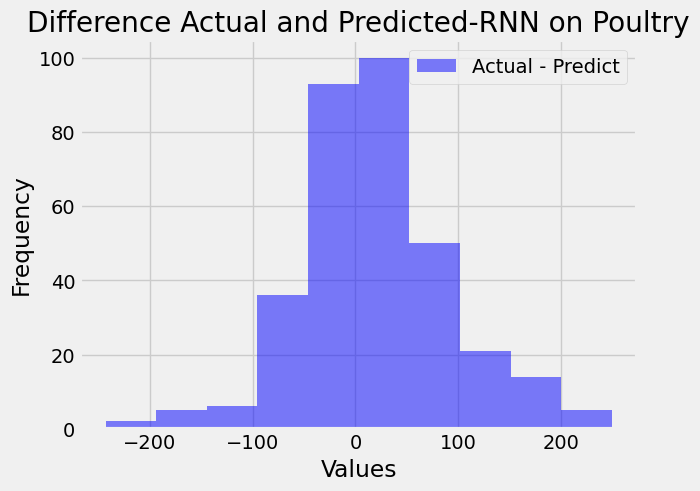

In [51]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.hist(results['Actual'] - results['Predict'], bins=10, alpha=0.5, color='blue', label='Actual - Predict')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Difference Actual and Predicted-RNN on Poultry')

# Adding legend
plt.legend()

# Display the plot
plt.show()

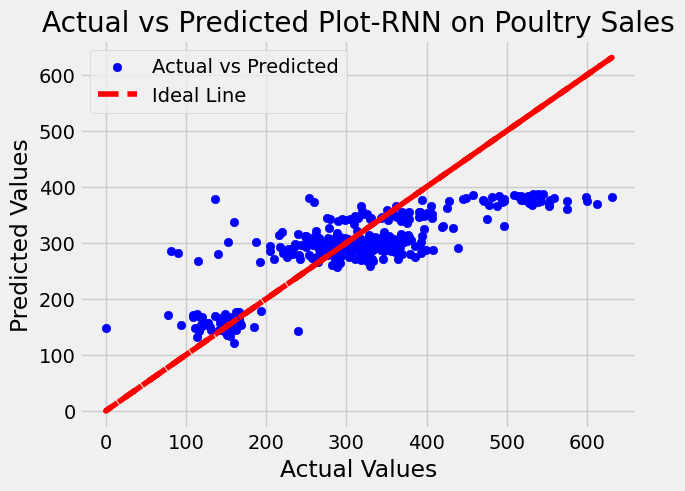

In [52]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.scatter(results['Actual'], results['Predict'], color='blue', label='Actual vs Predicted')
plt.plot(results['Actual'], results['Actual'], color='red', linestyle='--', label='Ideal Line')  # Plotting the ideal line (y = x)

# Adding labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Plot-RNN on Poultry Sales')

# Adding legend
plt.legend()

# Display the plot
plt.show()